# Analysing Pedestrians in Zurich's Bahnhofstrasse

https://opendata.swiss/de/dataset/passantenfrequenzen-an-der-bahnhofstrasse-stundenwerte

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
import json

theme_set(theme_bw())
pd.options.display.max_columns = 500
%load_ext blackcellmagic

In [2]:
# Open the JSON file for reading
with open("hystreet_locations.json", 'r') as file:
    # Load the JSON data into a Python object
    data = json.load(file)

data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': 331,
   'geometry': {'type': 'Polygon',
    'coordinates': [[[8.538222, 47.374015],
      [8.538598, 47.374015],
      [8.538694, 47.374211],
      [8.538823, 47.374429],
      [8.538845, 47.374654],
      [8.539445, 47.375744],
      [8.539767, 47.376427],
      [8.540025, 47.376812],
      [8.539681, 47.376921],
      [8.539177, 47.375897],
      [8.538845, 47.375272],
      [8.538501, 47.374582],
      [8.538222, 47.374015]]]},
   'properties': {'hystreet_location_id': 331,
    'name': 'Bahnhofstrasse (Nord)',
    'city': 'Zürich'}},
  {'type': 'Feature',
   'id': 329,
   'geometry': {'type': 'Polygon',
    'coordinates': [[[8.538947, 47.370233],
      [8.539215, 47.370273],
      [8.538936, 47.371039],
      [8.53863, 47.371879],
      [8.538453, 47.372373],
      [8.538405, 47.37315],
      [8.538383, 47.373735],
      [8.538405, 47.373848],
      [8.538099, 47.373811],
      [8.538099, 47.373753],
      [8.5

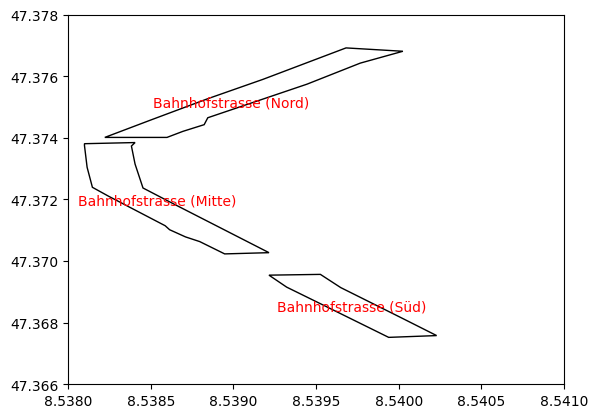

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Extracting features
features = data['features']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each polygon
for feature in features:
    coordinates = feature['geometry']['coordinates'][0]
    polygon = Polygon(coordinates, edgecolor='black', facecolor='none')
    ax.add_patch(polygon)

    # Add text label
    label = feature['properties']['name']
    centroid_x = sum(coord[0] for coord in coordinates) / len(coordinates)
    centroid_y = sum(coord[1] for coord in coordinates) / len(coordinates)
    ax.text(centroid_x, centroid_y, label, ha='center', va='center', color='red')

# Set axis limits
ax.set_xlim([8.538, 8.541])
ax.set_ylim([47.366, 47.378])

# Show the plot
plt.show()

### Using `seaborn` for visualisations

In [4]:
data = pd.read_csv(
    "hystreet_fussgaengerfrequenzen_seit2021.csv", parse_dates=["timestamp"]
).filter(
    [
        "timestamp",
        "location_name",
        "weather_condition",
        "temperature",
        "pedestrians_count",
    ]
)

In [5]:
data.head()

,timestamp,location_name,weather_condition,temperature,pedestrians_count
0,2021-09-28 22:00:00+00:00,Bahnhofstrasse (Mitte),cloudy,13.51,151
1,2021-09-28 22:00:00+00:00,Bahnhofstrasse (Nord),cloudy,13.51,118
2,2021-09-28 22:00:00+00:00,Bahnhofstrasse (Süd),cloudy,13.51,203
3,2021-09-28 23:00:00+00:00,Bahnhofstrasse (Mitte),cloudy,13.46,19
4,2021-09-28 23:00:00+00:00,Bahnhofstrasse (Nord),cloudy,13.46,7


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51759 entries, 0 to 51758
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          51759 non-null  datetime64[ns, UTC]
 1   location_name      51759 non-null  object             
 2   weather_condition  51759 non-null  object             
 3   temperature        51759 non-null  float64            
 4   pedestrians_count  51759 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(2)
memory usage: 2.0+ MB


### Different Locations

As the resolution is hourly, let's aggregate to daily values, in order to prevent showing a lot of low numbers during the nights.

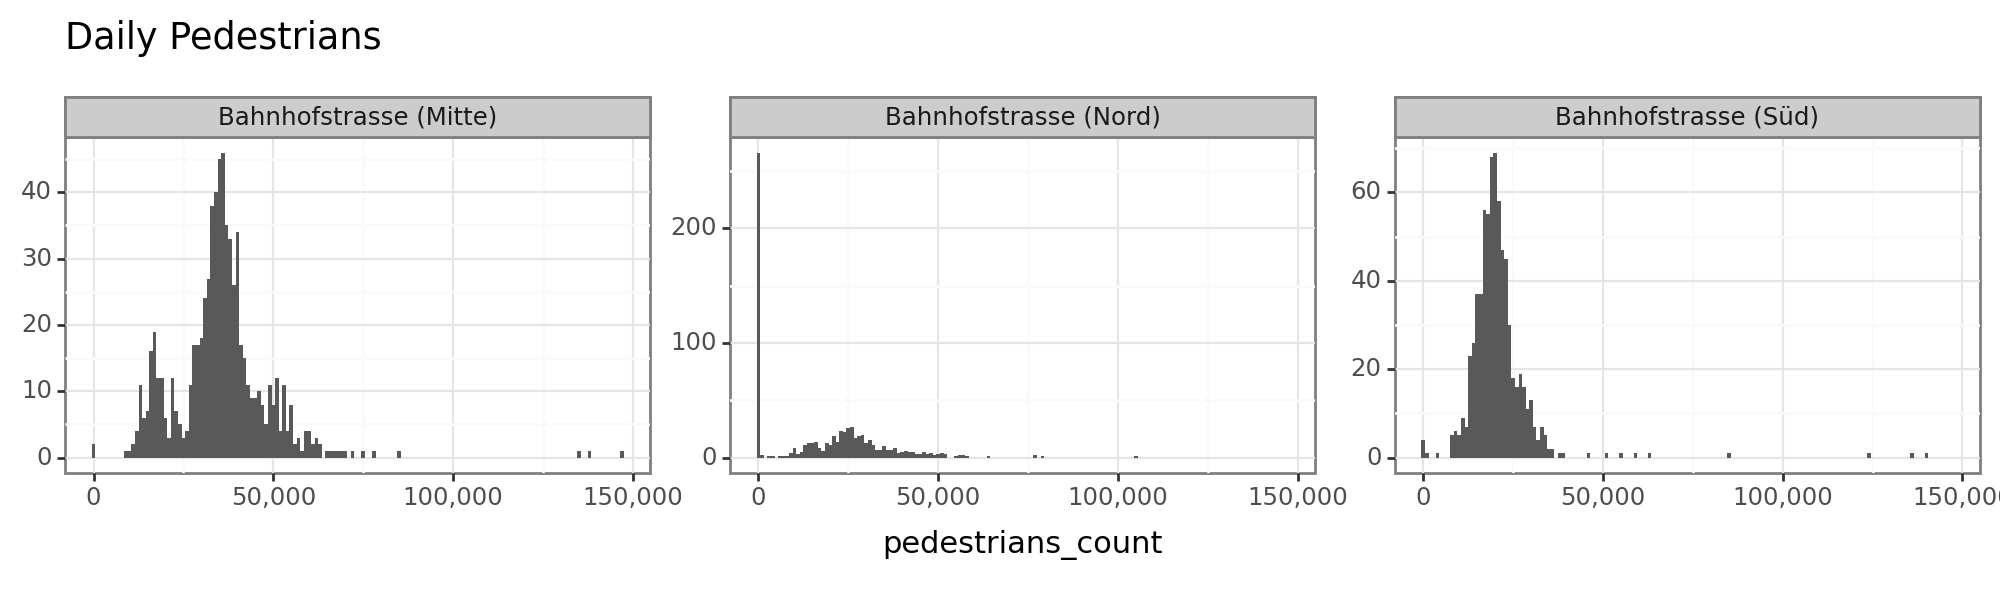

<Figure Size: (1000 x 300)>

In [7]:
(
    ggplot(
        data=data.assign(date=lambda x: x.timestamp.dt.date)
        .drop("timestamp", axis=1)
        .groupby(["date", "location_name"])
        .agg(pedestrians_count=("pedestrians_count", np.sum))
        .reset_index(),
        mapping=aes("pedestrians_count"),
    )
    + geom_histogram(binwidth=1000)
    + facet_wrap("location_name", scales="free_y")
    + labs(title = "Daily Pedestrians")
    + scale_x_continuous(labels=comma_format())
    + theme(figure_size=[10, 3], axis_title_y=element_blank())
)

It looks like something is off with the zero counts for "Nord", therefore, let's just carry on analysing "Mitte":

In [8]:
data = data.query("location_name.str.contains('Mitte')").reset_index(drop=True)

### Influence of Weather on Crowdedness

In [9]:
data.value_counts("weather_condition")

weather_condition
cloudy                 3917
partly-cloudy-day      3901
partly-cloudy-night    3449
rain                   2784
clear-day              1645
clear-night            1379
fog                      96
snow                     62
wind                     20
Name: count, dtype: int64

Plot daily visitors by weather condition. Use majority class for entire day.

In [10]:
(
    data.assign(
        hour=lambda x: x.timestamp.dt.hour + 1, date=lambda x: x.timestamp.dt.date
    )
    .query("hour > 9 and hour < 18")
    .groupby("date")
    .apply(
        lambda x: pd.Series(
            {
                "weather_condition": x.weather_condition.mode()[0],
                "pedestrians_count": x.pedestrians_count.sum(),
            }
        )
    )
    .reset_index()
    .assign(
        weather_condition=lambda x: np.select(
            condlist=[
                x.weather_condition == "partly-cloudy-day",
                x.weather_condition == "clear-day",
            ],
            choicelist=[
                "partly-cloudy",
                "clear",
            ],
            default=x.weather_condition,
        )
    )
)

,date,weather_condition,pedestrians_count
0,2021-09-29,partly-cloudy,22087
1,2021-09-30,partly-cloudy,23482
2,2021-10-01,partly-cloudy,25437
3,2021-10-02,partly-cloudy,40498
4,2021-10-03,cloudy,11035
...,...,...,...
714,2023-09-13,rain,24713
715,2023-09-14,partly-cloudy,27622
716,2023-09-15,partly-cloudy,30876
717,2023-09-16,partly-cloudy,39109


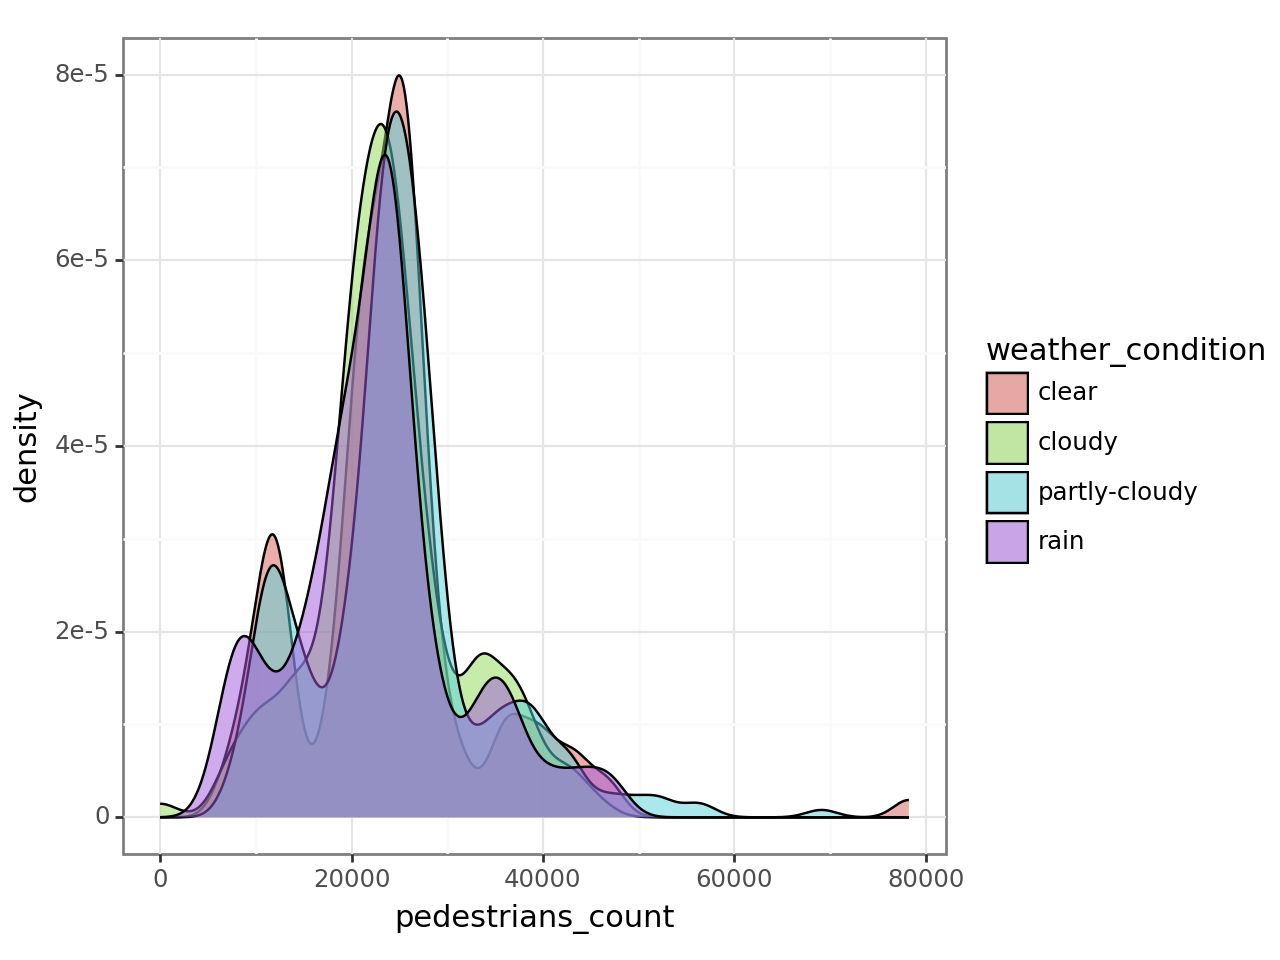

<Figure Size: (640 x 480)>

In [11]:
(
    ggplot(
        data=(
            data.assign(
                hour=lambda x: x.timestamp.dt.hour + 1,
                date=lambda x: x.timestamp.dt.date,
            )
            .query("hour > 9 and hour < 18")
            .groupby("date")
            .apply(
                lambda x: pd.Series(
                    {
                        "weather_condition": x.weather_condition.mode()[0],
                        "pedestrians_count": x.pedestrians_count.sum(),
                    }
                )
            )
            .reset_index()
            .assign(
                weather_condition=lambda x: np.select(
                    condlist=[
                        x.weather_condition == "partly-cloudy-day",
                        x.weather_condition == "clear-day",
                    ],
                    choicelist=[
                        "partly-cloudy",
                        "clear",
                    ],
                    default=x.weather_condition,
                )
            )
            .query("weather_condition not in ['snow', 'wind', 'fog']")
        ),
        mapping=aes(x="pedestrians_count", fill="weather_condition"),
    )
    + geom_density(alpha=0.5)
)

In [12]:
(
            data.assign(
                hour=lambda x: x.timestamp.dt.hour + 1,
                date=lambda x: pd.to_datetime(x.timestamp.dt.date)
            )
            .query("hour > 9 and hour < 18")
            .groupby("date")
            .apply(
                lambda x: pd.Series(
                    {
                        "weather_condition": x.weather_condition.mode()[0],
                        "pedestrians_count": x.pedestrians_count.sum()
                    }
                )
            )
            .reset_index()
            .assign(
                weather_condition=lambda x: np.where(x.weather_condition == "rain", "rain", "not rain"),
                wday=lambda x: x.date.dt.day_of_week + 1
                )
        )

,date,weather_condition,pedestrians_count,wday
0,2021-09-29,not rain,22087,3
1,2021-09-30,not rain,23482,4
2,2021-10-01,not rain,25437,5
3,2021-10-02,not rain,40498,6
4,2021-10-03,not rain,11035,7
...,...,...,...,...
714,2023-09-13,rain,24713,3
715,2023-09-14,not rain,27622,4
716,2023-09-15,not rain,30876,5
717,2023-09-16,not rain,39109,6


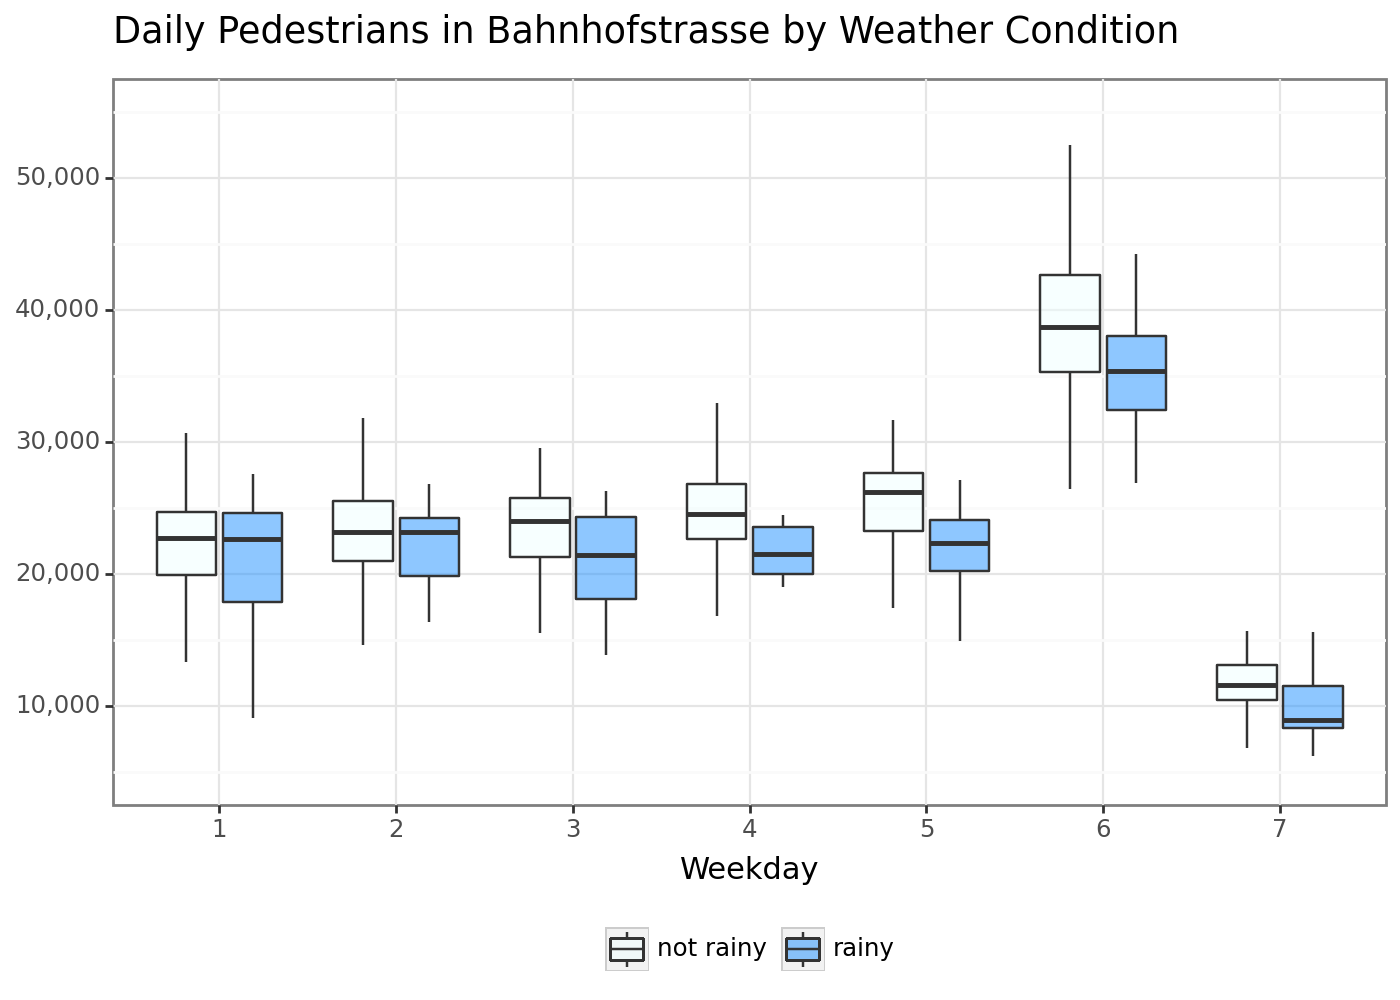

<Figure Size: (700 x 500)>

In [13]:
(
    ggplot(
        data=(
            data.assign(
                hour=lambda x: x.timestamp.dt.hour + 1,
                date=lambda x: pd.to_datetime(x.timestamp.dt.date)
            )
            .query("hour > 9 and hour < 18")
            .groupby("date")
            .apply(
                lambda x: pd.Series(
                    {
                        "weather_condition": x.weather_condition.mode()[0],
                        "pedestrians_count": x.pedestrians_count.sum()
                    }
                )
            )
            .reset_index()
            .assign(
                weather_condition=lambda x: np.where(x.weather_condition == "rain", "rainy", "not rainy"),
                wday=lambda x: (x.date.dt.day_of_week + 1).astype(str)
                )
        ),
        mapping=aes(x="wday", y="pedestrians_count", fill="weather_condition"),
    )
    + geom_boxplot(alpha=0.5, outlier_colour="none")
    + coord_cartesian(ylim=[5000, 55000]) 
    + labs(title="Daily Pedestrians in Bahnhofstrasse by Weather Condition",
           x="Weekday")
    + scale_y_continuous(labels=comma_format())
    + scale_fill_manual(values=["azure", "dodgerblue"])
    + theme(figure_size=[7, 5],
            legend_position="bottom",
            legend_title=element_blank(),
            axis_title_y=element_blank())
)

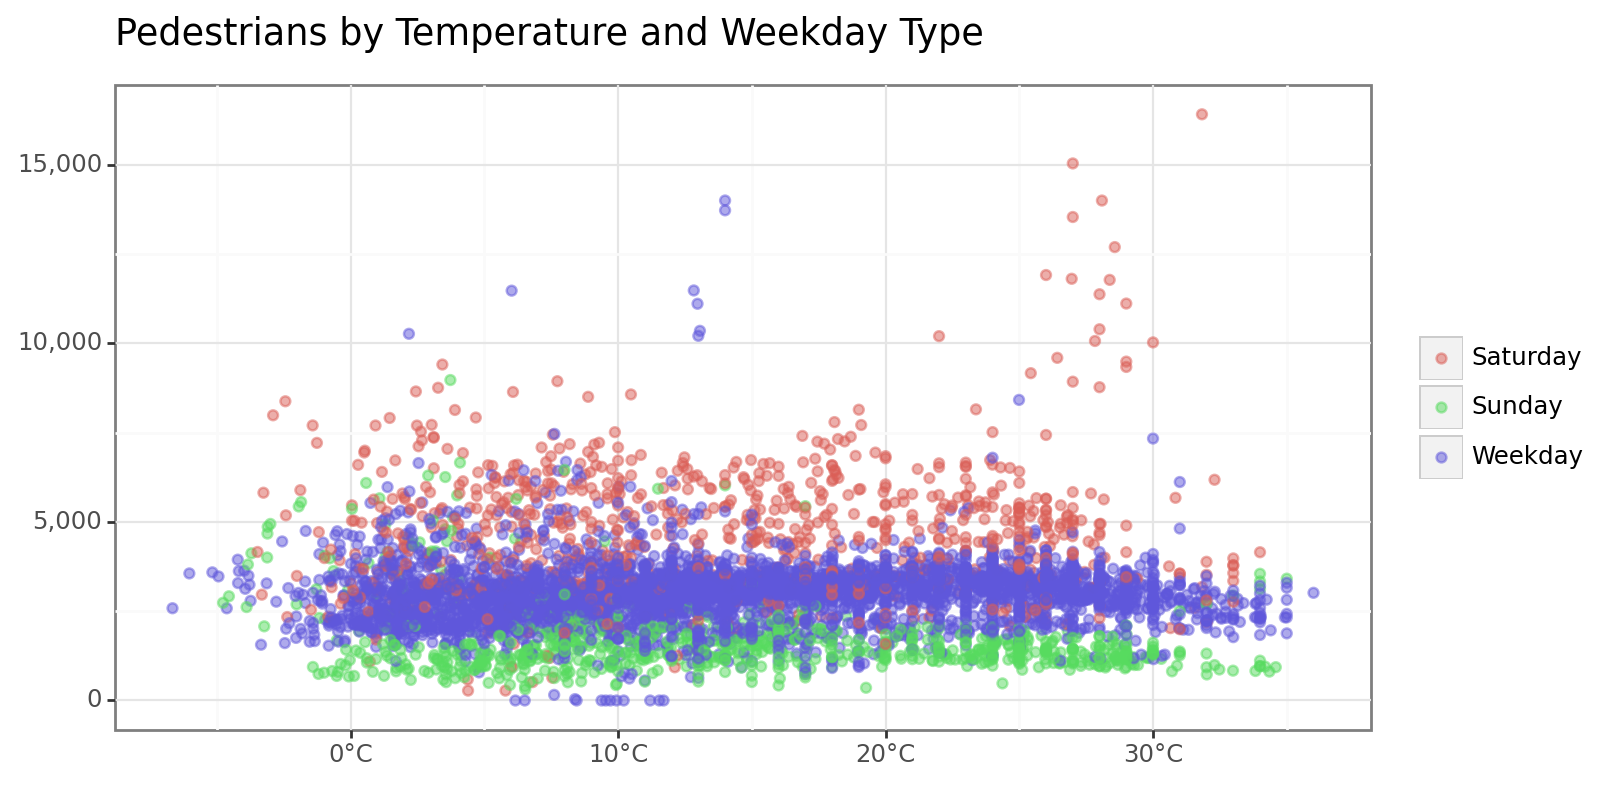

<Figure Size: (800 x 400)>

In [14]:
(ggplot(data=(
    data.assign(
        hour=lambda x: x.timestamp.dt.hour,
        wday=lambda x: x.timestamp.dt.day_of_week + 1,
        label=lambda x: np.select(
            condlist=[
                x.wday.isin(np.arange(1, 6)),
                x.wday == 6,
                x.wday == 7,
            ],
            choicelist=["Weekday", "Saturday", "Sunday"],
            default=pd.NA
        ),
    ).query("hour > 9 and hour < 18")
),
        mapping=aes("temperature", "pedestrians_count", colour="label"))
    + geom_point(alpha = 0.5)
    + labs(title="Pedestrians by Temperature and Weekday Type")
    + scale_y_continuous(labels=comma_format())
    + scale_x_continuous(labels=currency_format(prefix="", suffix="°C", digits=0))
    + theme(figure_size=[8, 4],
            axis_title=element_blank(),
            legend_title=element_blank())
)

### Influence of Time

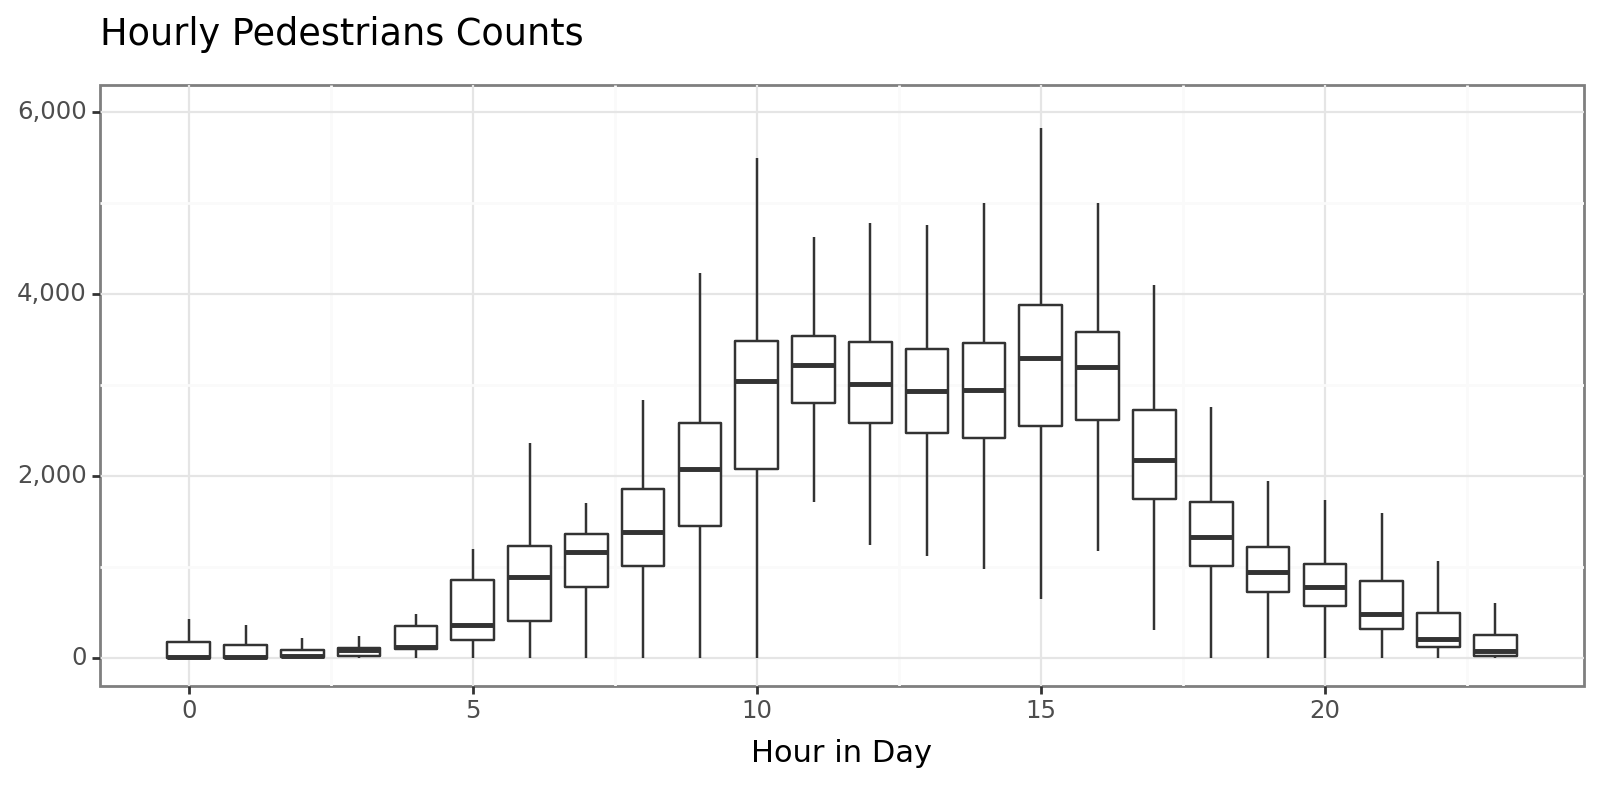

<Figure Size: (800 x 400)>

In [15]:
(
    ggplot(
        data=data.assign(hour=lambda x: x.timestamp.dt.hour),
        mapping=aes(x="hour", y="pedestrians_count", group="hour"),
    )
    + geom_boxplot(outlier_shape="none")
    + coord_cartesian(ylim=[0, 6000])
    + labs(title="Hourly Pedestrians Counts", x="Hour in Day")
    + scale_y_continuous(labels=comma_format())
    + theme(figure_size=[8, 4], axis_title_y=element_blank())
)

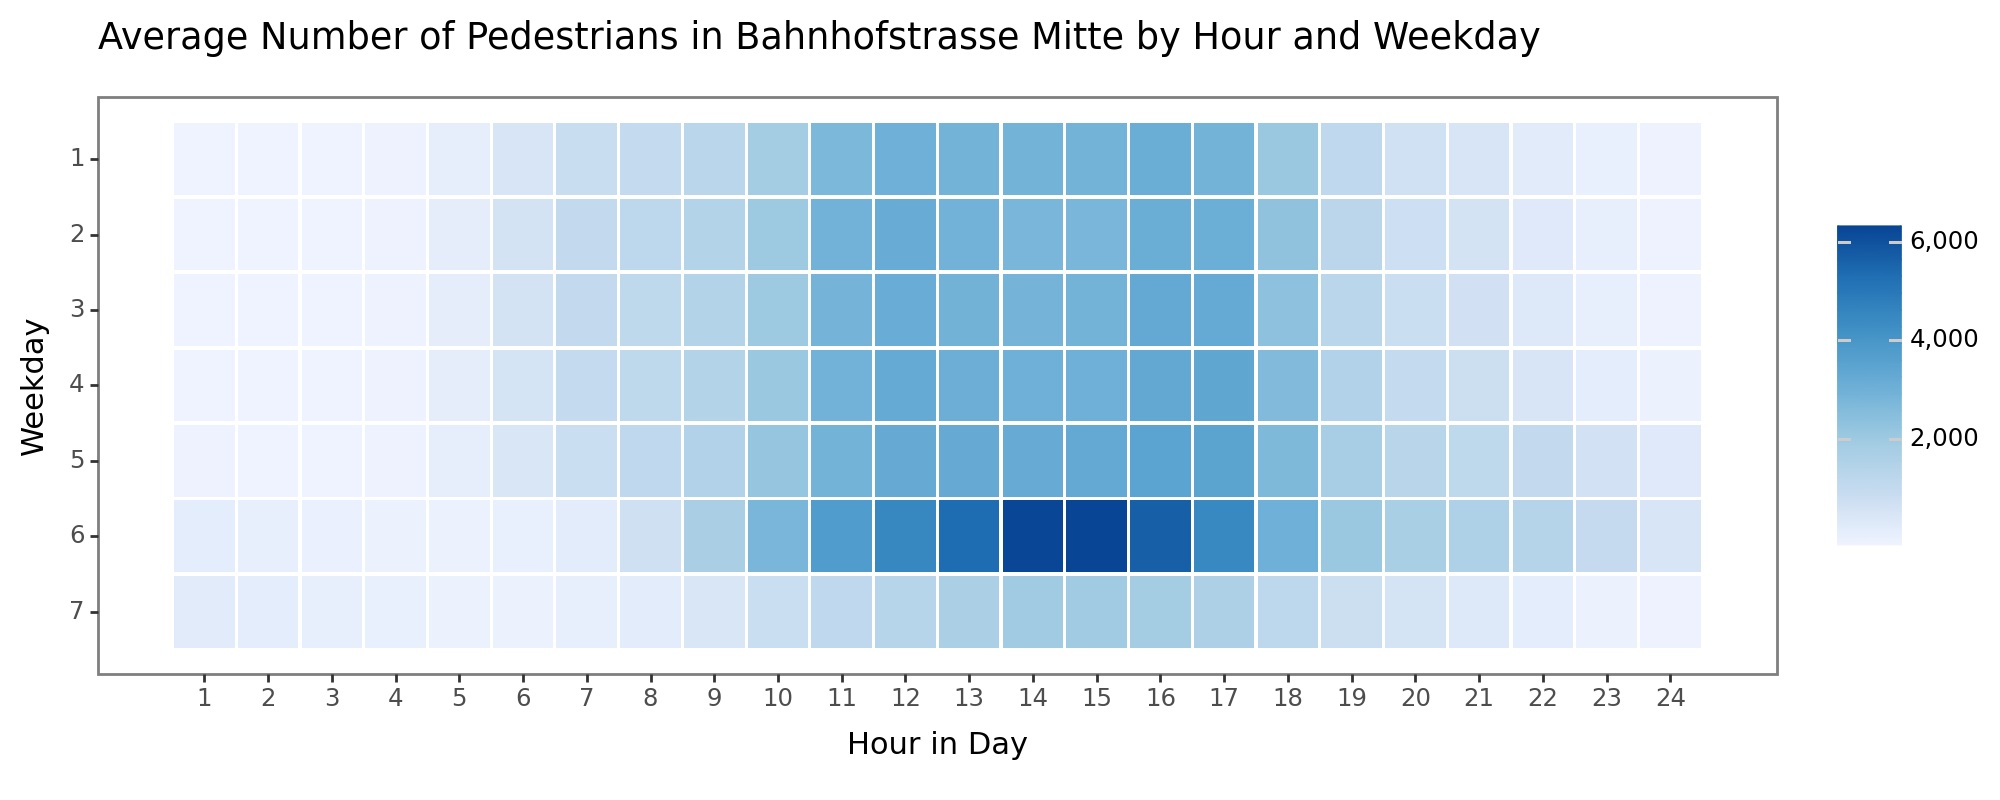

<Figure Size: (1000 x 400)>

In [464]:
(
    ggplot(
        data=(
            data.assign(
                hour=lambda x: x.timestamp.dt.hour + 1,
                wday=lambda x: x.timestamp.dt.weekday + 1,
            )
            .groupby(["hour", "wday"])
            .agg(pedestrians_count=("pedestrians_count", np.mean))
            .reset_index()
        ),
        mapping=aes(x="hour", y="wday", fill="pedestrians_count"),
    )
    + geom_tile(aes(width=0.95, height=0.95))
    + labs(
        title="Average Number of Pedestrians in Bahnhofstrasse Mitte by Hour and Weekday", y="Weekday", x="Hour in Day",
    )
    + scale_x_continuous(breaks=np.arange(1, 25))
    + scale_y_reverse(breaks=np.arange(1, 8))
    + scale_fill_distiller(type="seq", direction=1, labels=comma_format())
    + theme(figure_size=[10, 4],
            panel_grid = element_blank(),
            legend_title=element_blank())
)

### Influence of the Christmas Season

In [388]:
(
    data.assign(date=lambda x: x.timestamp.dt.date.pipe(pd.to_datetime))
    .groupby("date")
    .apply(
        lambda x: pd.Series(
            {
                "pedestrians_count": x.pedestrians_count.sum(),
            }
        )
    )
    .reset_index()
    .assign(
        day=lambda x: x.date.dt.day,
        month=lambda x: x.date.dt.month + 1,
        season=lambda x: np.where(
            (x.month == 12) & ((x.day >= 1) & (x.day <= 24)),
            "Christmas-Season",
            "Offseason",
        ),
    )
).value_counts("season")

season
Offseason           672
Christmas-Season     48
Name: count, dtype: int64

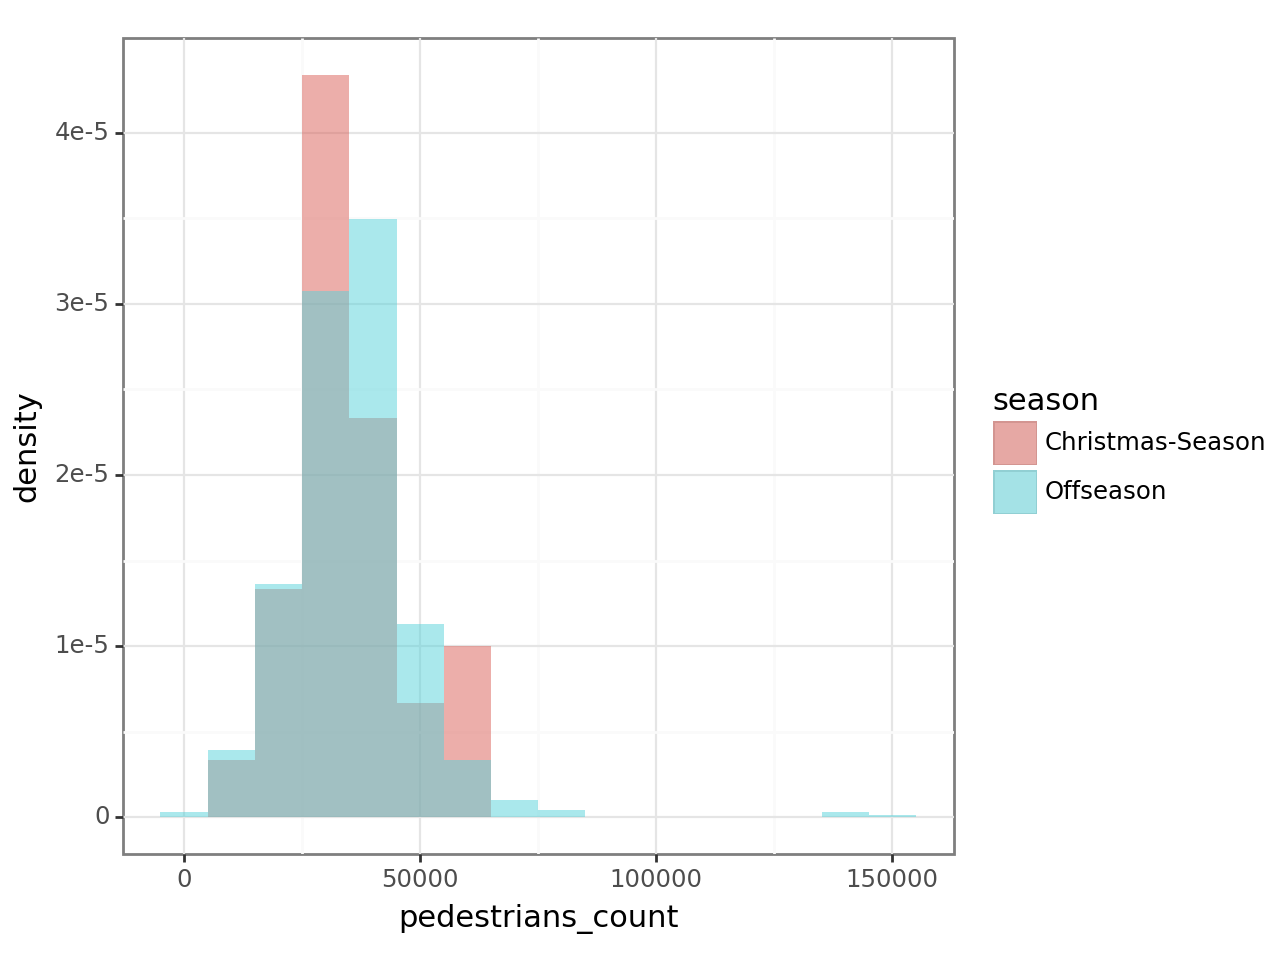

<Figure Size: (640 x 480)>

In [409]:
(ggplot(data=(
    data.assign(date=lambda x: x.timestamp.dt.date.pipe(pd.to_datetime))
    .groupby("date")
    .apply(
        lambda x: pd.Series(
            {
                "pedestrians_count": x.pedestrians_count.sum(),
            }
        )
    )
    .reset_index()
    .assign(
        day=lambda x: x.date.dt.day,
        month=lambda x: x.date.dt.month + 1,
        season=lambda x: np.where(
            (x.month == 12) & ((x.day >= 10) & (x.day <= 24)),
            "Christmas-Season",
            "Offseason",
        ),
    )
),
mapping=aes(x="pedestrians_count", fill="season"))
+ geom_histogram(aes(y=after_stat("density")), binwidth=10000, alpha=0.5, position="identity")
)

In [415]:
(
    data.assign(date=lambda x: x.timestamp.dt.date.pipe(pd.to_datetime), 
                hour=lambda x: x.timestamp.dt.hour)
    .query("hour > 15 and hour < 21")
    .groupby("date")
    .apply(
        lambda x: pd.Series(
            {
                "pedestrians_count": x.pedestrians_count.sum(),
            }
        )
    )
    .reset_index()
    .assign(
        day=lambda x: x.date.dt.day,
        month=lambda x: x.date.dt.month + 1,
        season=lambda x: np.where(
            (x.month == 12) & ((x.day >= 10) & (x.day <= 24)),
            "Christmas-Season",
            "Offseason",
        ),
    )
    .groupby("season")["pedestrians_count"].mean()
)

season
Christmas-Season    10403.866667
Offseason            8926.529753
Name: pedestrians_count, dtype: float64